#  Validation of the model

In [120]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import  AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from dataset.dataset import get_twenty_dataset, get_IMDB_dataset
from main_dataset import main

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')
from sklearn.externals import joblib

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
from datetime import datetime
import time
plt.style.use('seaborn')
%matplotlib inline

Get dataset

In [2]:
# We compare the condition where datasets are
# 1. tf-idf
# 2. tf-idf + remove_stopping_word
# 3. tf-idf + remove_stopping_word + SVD (k=2,3,4,5,6)
# 4. tf-idf + remove_stopping_word + autoencoder, autoencoder fails to fit such large volume data
twenty_dataset_dict = {}
IMDB_dataset_dict = {}

# 1.
twenty_dataset_dict[0]= list(get_twenty_dataset())
IMDB_dataset_dict [0] = list(get_IMDB_dataset())

# 2.
twenty_dataset_dict[1]= list(get_twenty_dataset(remove_stop_word=True))
IMDB_dataset_dict [1] = list(get_IMDB_dataset(remove_stop_word=True))

# 3. 
for i in range(2,7):
    print(i)
    twenty_dataset_dict[i]= list(get_twenty_dataset(remove_stop_word=True,preprocessing_trick='SVD',n_components=i))
    IMDB_dataset_dict [i] = list(get_IMDB_dataset(remove_stop_word=True,preprocessing_trick='SVD',n_components=i)) 
# x_train_20, y_train_20, x_test_20, y_test_20 = get_twenty_dataset()
# x_train_imdb, y_train_imdb, x_test_imdb, y_test_imdb = get_IMDB_dataset()

# 4.
#twenty_dataset_dict[7]= list(get_twenty_dataset(remove_stop_word=True,preprocessing_trick='autoencoder',n_components=256))
#IMDB_dataset_dict [7] = list(get_IMDB_dataset(remove_stop_word=True,preprocessing_trick='autoencoder',n_components=256))

2
3
4
5
6


Store the name of the proposed processed data

In [58]:
dataset_list = ['tf-idf','tf-idf, remove stopping word','SVD-2','SVD-3','SVD-4','SVD-5','SVD-6']

# Pipeline
We create pipelines for models that need parameter tuning and those who do not. To be noticed that it does not mean that the latter models are parameter-free, instead, it is computationally heavy to re-train these models.

## Parameter-tuning models

In [52]:
# Define Parameter-tuning classifiers
clf_NB = MultinomialNB()
clf_LR = LogisticRegression()
clf_DT = DecisionTreeClassifier()
clf_SVC = LinearSVC()
clf_ADB = AdaBoostClassifier()
clf_RDF = RandomForestClassifier()

models_dict = {'NB':clf_NB,'LR': clf_LR,'DT':clf_DT,'SVC':clf_SVC,'ADB':clf_ADB,'RDF':clf_RDF}
#models_dict = {'NB':clf_NB}
models_list = list(models_dict.items())

In [53]:
# Define tunable parameters ranges for different classifiers
para_NB = {'NB__alpha':np.arange(0,2,0.2),'NB__fit_prior':[True,False]}
para_LR = {'LR__penalty':['l1','l2','elasticnet'],
           'LR__warm_start':[True,False]}
para_DT = {'DT__criterion':['gini','entropy'],
           'DT__max_features': ['sqrt','log2',None]}
para_SVC = {'SVC__penalty': ['l1','l2'],
            'SVC__loss': ['hinge','squared_hinge']}
para_ADB = {'ADB__n_estimators': [30,50,80,100,120],
            'ADB__learning_rate':np.arange(0,1.2,0.2)}
para_RDF = {'RDF__max_depth':[20,40,60],'RDF__n_estimators':[50,100,150]}

params_list = [para_NB,para_LR,para_DT,para_SVC,para_ADB,para_RDF]
#params_list = [para_NB]

Make sure the model list is the same as parameters list

In [42]:
print( len(models_list) == len(params_list) )

True


This is the model specifics which are the same for both datasets

In [ ]:
# Gridsearch and record scores and runtime
grid_dict_20 = {'NB':None,'LR': None,'DT':None,'SVC':None,'ADB':None,'RDF':None}
grid_dict_imdb = {'NB':None,'LR': None,'DT':None,'SVC':None,'ADB':None,'RDF':None}
scores = np.zeros((2,len(models_list),len(dataset_list)))
runtimes_best_models = np.zeros((2,len(models_list),len(dataset_list)))

k = 5 # Magic number
n_jobs =5

for idx,model_item in tqdm_notebook(enumerate(models_list),total=len(models_list)):
    pipline = Pipeline([model_item])
    print('#'*20)
    # For 20 news
    grid_20 = GridSearchCV(pipline,param_grid=params_list[idx],cv=k,
                        error_score=0.0,n_jobs=n_jobs,refit=True)
    # For imdb
    grid_imdb = GridSearchCV(pipline,param_grid=params_list[idx],cv=k,
                        error_score=0.0,n_jobs=n_jobs,refit=True)
    
    for dataset_idx in range(len(twenty_dataset_dict)):
        try:
            grid_20.fit(twenty_dataset_dict[dataset_idx][0],twenty_dataset_dict[dataset_idx][1])
            scores[0,idx,dataset_idx] = grid_20.score(twenty_dataset_dict[dataset_idx][2], twenty_dataset_dict[dataset_idx][3])
            runtimes_best_models[0,idx,dataset_idx] = grid_20.refit_time_
            print('Model ',model_item[0],' for 20 news ' , dataset_list[dataset_idx] , 'score = %3.4f'%(scores[0,idx,dataset_idx]),' runtime = %3.4f s'%(runtimes_best_models[0,idx,dataset_idx]))
            print('Model ',model_item[0],' for 20 news  ' , dataset_list[dataset_idx] ,'best params', grid_20.best_params_)
            if grid_dict_20[model_item[0]] is None or scores[0,idx,dataset_idx]>grid_dict_20[model_item[0]].score(twenty_dataset_dict[dataset_idx][2], twenty_dataset_dict[dataset_idx][3]):
                grid_dict_20[model_item[0]] = grid_20



            grid_imdb.fit(IMDB_dataset_dict[dataset_idx][0],IMDB_dataset_dict[dataset_idx][1])
            scores[1,idx,dataset_idx] = grid_imdb.score(IMDB_dataset_dict[dataset_idx][2], IMDB_dataset_dict[dataset_idx][3])
            runtimes_best_models[1,idx,dataset_idx] = grid_imdb.refit_time_
            print('Model ',model_item[0],' for IMDB ' , dataset_list[dataset_idx],'score = %3.4f'%(scores[1,idx,dataset_idx]),' runtime = %3.4f s'%(runtimes_best_models[0,idx,dataset_idx]))
            print('Model ',model_item[0],' for IMDB ' , dataset_list[dataset_idx] ,' best params', grid_imdb.best_params_)
            if grid_dict_imdb[model_item[0]] is None or scores[1,idx,dataset_idx]>grid_dict_imdb[model_item[0]].score(IMDB_dataset_dict[dataset_idx][2], IMDB_dataset_dict[dataset_idx][3]):
                grid_dict_imdb[model_item[0]] = grid_imdb
        except ValueError as e:
            print('Model ',model_item[0], ' is not suitable for non-negative value in preprocessing ',dataset_list[dataset_idx])
        print('-'*10)
        
joblib.dump(grid_dict_20,'dump_model_joblib/grid_dict_20_tuned.joblib')
joblib.dump(grid_dict_imdb,'dump_model_joblib/grid_dict_imdb_tuned.joblib')
joblib.dump(scores,'dump_model_joblib/scores_tuned.joblib')
joblib.dump(runtimes_best_models,'dump_model_joblib/runtimes_best_models_tuned.joblib')

####################
Model  NB  for 20 news  tf-idf score = 0.7463  runtime = 0.0636 s
Model  NB  for 20 news   tf-idf best params {'NB__alpha': 0.0, 'NB__fit_prior': True}
Model  NB  for IMDB  tf-idf score = 0.8317  runtime = 0.0636 s
Model  NB  for IMDB  tf-idf  best params {'NB__alpha': 1.8, 'NB__fit_prior': True}
----------
Model  NB  for 20 news  tf-idf, remove stopping word score = 0.7979  runtime = 0.0659 s
Model  NB  for 20 news   tf-idf, remove stopping word best params {'NB__alpha': 0.2, 'NB__fit_prior': False}
Model  NB  for IMDB  tf-idf, remove stopping word score = 0.8380  runtime = 0.0659 s
Model  NB  for IMDB  tf-idf, remove stopping word  best params {'NB__alpha': 1.8, 'NB__fit_prior': True}
----------
Model  NB  is not suitable for non-negative value in preprocessing  SVD-2
----------
Model  NB  is not suitable for non-negative value in preprocessing  SVD-3
----------
Model  NB  is not suitable for non-negative value in preprocessing  SVD-4
----------
Model  NB  is not

Model  ADB  for 20 news  tf-idf score = 0.5046  runtime = 16.8110 s
Model  ADB  for 20 news   tf-idf best params {'ADB__learning_rate': 0.6000000000000001, 'ADB__n_estimators': 100}
Model  ADB  for IMDB  tf-idf score = 0.8357  runtime = 16.8110 s
Model  ADB  for IMDB  tf-idf  best params {'ADB__learning_rate': 0.6000000000000001, 'ADB__n_estimators': 120}
----------
Model  ADB  for 20 news  tf-idf, remove stopping word score = 0.5127  runtime = 15.1223 s
Model  ADB  for 20 news   tf-idf, remove stopping word best params {'ADB__learning_rate': 0.4, 'ADB__n_estimators': 120}
Model  ADB  for IMDB  tf-idf, remove stopping word score = 0.8359  runtime = 15.1223 s
Model  ADB  for IMDB  tf-idf, remove stopping word  best params {'ADB__learning_rate': 0.6000000000000001, 'ADB__n_estimators': 120}
----------
Model  ADB  for 20 news  SVD-2 score = 0.1483  runtime = 0.2544 s
Model  ADB  for 20 news   SVD-2 best params {'ADB__learning_rate': 0.4, 'ADB__n_estimators': 30}
Model  ADB  for IMDB  SVD-

## Models free from parameter tuning
We train these computationally heavy model once and then save them for future ploting.

In [61]:
clf_NN = MLPClassifier() # Computationally heavy to tune NN
clf_XG = XGBClassifier()

models_dict_notuning = {'NN':clf_NN,'XG':clf_XG}
models_list_notuning = list(models_dict_notuning.items())

# The model parameters are fixed
para_NN = {'NN__solver':['lbfgs'], 'NN__hidden_layer_sizes' :[(30,1024)],'NN__max_iter':[5000] }
para_XG = {'XG__learning_rate':[0.1]}

params_list_notuning = [para_NN,para_XG]

print( len(models_list_notuning) == len(params_list_notuning) )

True


In [62]:
# Using the same strucuture above
grid_dict_20 = {}
grid_dict_imdb = {}
scores = np.zeros((2,len(models_list_notuning),len(dataset_list)))
runtimes_best_models = np.zeros((2,len(models_list_notuning),len(dataset_list)))

k = 5 # Magic number
n_jobs =5

for idx,model_item in tqdm_notebook(enumerate(models_list_notuning),total=len(models_list_notuning)):
    pipline = Pipeline([model_item])
    print('#'*20)
    # For 20 news
    grid_20 = GridSearchCV(pipline,param_grid=params_list_notuning[idx],cv=k,
                        error_score=0.0,n_jobs=n_jobs,refit=True)
    # For imdb
    grid_imdb = GridSearchCV(pipline,param_grid=params_list_notuning[idx],cv=k,
                        error_score=0.0,n_jobs=n_jobs,refit=True)
    
    for dataset_idx in range(len(twenty_dataset_dict)):
        try:
            grid_20.fit(twenty_dataset_dict[dataset_idx][0],twenty_dataset_dict[dataset_idx][1])
            scores[0,idx,dataset_idx] = grid_20.score(twenty_dataset_dict[dataset_idx][2], twenty_dataset_dict[dataset_idx][3])
            runtimes_best_models[0,idx,dataset_idx] = grid_20.refit_time_
            print('Model ',model_item[0],' for 20 news ' , dataset_list[dataset_idx] , 'score = %3.4f s'%(scores[0,idx,dataset_idx]),' runtime = %3.4f'%(runtimes_best_models[0,idx,dataset_idx]))
            print('Model ',model_item[0],' for 20 news  ' , dataset_list[dataset_idx] ,'best params', grid_20.best_params_)
            grid_dict_20[model_item[0]] = grid_20



            grid_imdb.fit(IMDB_dataset_dict[dataset_idx][0],IMDB_dataset_dict[dataset_idx][1])
            scores[1,idx,dataset_idx] = grid_imdb.score(IMDB_dataset_dict[dataset_idx][2], IMDB_dataset_dict[dataset_idx][3])
            runtimes_best_models[1,idx,dataset_idx] = grid_imdb.refit_time_
            print('Model ',model_item[0],' for IMDB ' , dataset_list[dataset_idx],'score = %3.4f s'%(scores[1,idx,dataset_idx]),' runtime = %3.4f'%(runtimes_best_models[0,idx,dataset_idx]))
            print('Model ',model_item[0],' for IMDB ' , dataset_list[dataset_idx] ,' best params', grid_imdb.best_params_)
            grid_dict_imdb[model_item[0]] = grid_imdb
        except ValueError as e:
            print('Model ',model_item[0], ' is not suitable for non-negative value in preprocessing ',dataset_list[dataset_idx])
        print('-'*10)
        
joblib.dump(grid_dict_20,'dump_model_joblib/grid_dict_20_nottuned.joblib')
joblib.dump(grid_dict_imdb,'dump_model_joblib/grid_dict_imdb_nottuned.joblib')
joblib.dump(scores,'dump_model_joblib/scores_nottuned.joblib')
joblib.dump(runtimes_best_models,'dump_model_joblib/runtimes_best_models_nottuned.joblib')

####################
Model  NN  for 20 news  tf-idf score = 0.7577 s  runtime = 334.3029
Model  NN  for 20 news   tf-idf best params {'NN__hidden_layer_sizes': (30, 1024), 'NN__max_iter': 5000, 'NN__solver': 'lbfgs'}
Model  NN  for IMDB  tf-idf score = 0.8776 s  runtime = 334.3029
Model  NN  for IMDB  tf-idf  best params {'NN__hidden_layer_sizes': (30, 1024), 'NN__max_iter': 5000, 'NN__solver': 'lbfgs'}
----------
Model  NN  for 20 news  tf-idf, remove stopping word score = 0.7379 s  runtime = 443.5841
Model  NN  for 20 news   tf-idf, remove stopping word best params {'NN__hidden_layer_sizes': (30, 1024), 'NN__max_iter': 5000, 'NN__solver': 'lbfgs'}
Model  NN  for IMDB  tf-idf, remove stopping word score = 0.8652 s  runtime = 443.5841
Model  NN  for IMDB  tf-idf, remove stopping word  best params {'NN__hidden_layer_sizes': (30, 1024), 'NN__max_iter': 5000, 'NN__solver': 'lbfgs'}
----------
Model  NN  for 20 news  SVD-2 score = 0.1937 s  runtime = 1333.4267
Model  NN  for 20 news   SVD-

['dump_model_joblib/runtimes_best_models_nottuned.joblib']

# Plot experiment result

Load the data and the pipeline

In [67]:
scores_tuned = joblib.load('dump_model_joblib/scores_tuned.joblib')
scores_nottuned = joblib.load('dump_model_joblib/scores_nottuned.joblib')

runtime_tuned = joblib.load('dump_model_joblib/runtimes_best_models_tuned.joblib')
runtime_nottuned = joblib.load('dump_model_joblib/runtimes_best_models_nottuned.joblib')

grid_dict_20_tuned = joblib.load('dump_model_joblib/grid_dict_20_tuned.joblib')
grid_dict_20_nottuned = joblib.load('dump_model_joblib/grid_dict_20_nottuned.joblib')

grid_dict_imdb_tuned = joblib.load('dump_model_joblib/grid_dict_imdb_tuned.joblib')
grid_dict_imdb_nottuned = joblib.load('dump_model_joblib/grid_dict_imdb_nottuned.joblib')
                                    
dataset_list = ['tf-idf','tf-idf & remove stopping word','SVD-2','SVD-3','SVD-4','SVD-5','SVD-6']
model_name_list = ['NB','LR','DT','SVM','ADB','RDF','MLP','XG']

Concatenate the tuned model and nottuned model results into one varibale

In [68]:
scores = np.concatenate((scores_tuned,scores_nottuned),axis=1)
runtime = np.concatenate((runtime_tuned,runtime_nottuned),axis=1)
print('Accuracy concatenation: ',scores_tuned.shape,scores_nottuned.shape,'-->',scores.shape)
print('Runtime concatenation: ',runtime_tuned.shape,runtime_nottuned.shape,'-->',runtime.shape)

Accuracy concatenation:  (2, 6, 7) (2, 2, 7) --> (2, 8, 7)
Runtime concatenation:  (2, 6, 7) (2, 2, 7) --> (2, 8, 7)


In [188]:
colors = ['cornflowerblue','gold','palegreen','lightcoral','violet','tan','lightpink','grey']
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',color='black')
        
def labelmax(rect,model_idx):
    """Mark the best perform model """
    height = rect[model_idx].get_height()
    ax.annotate('{:.3}'.format(height),
                xy=(rect[model_idx].get_x() + rect[model_idx].get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',color='red')

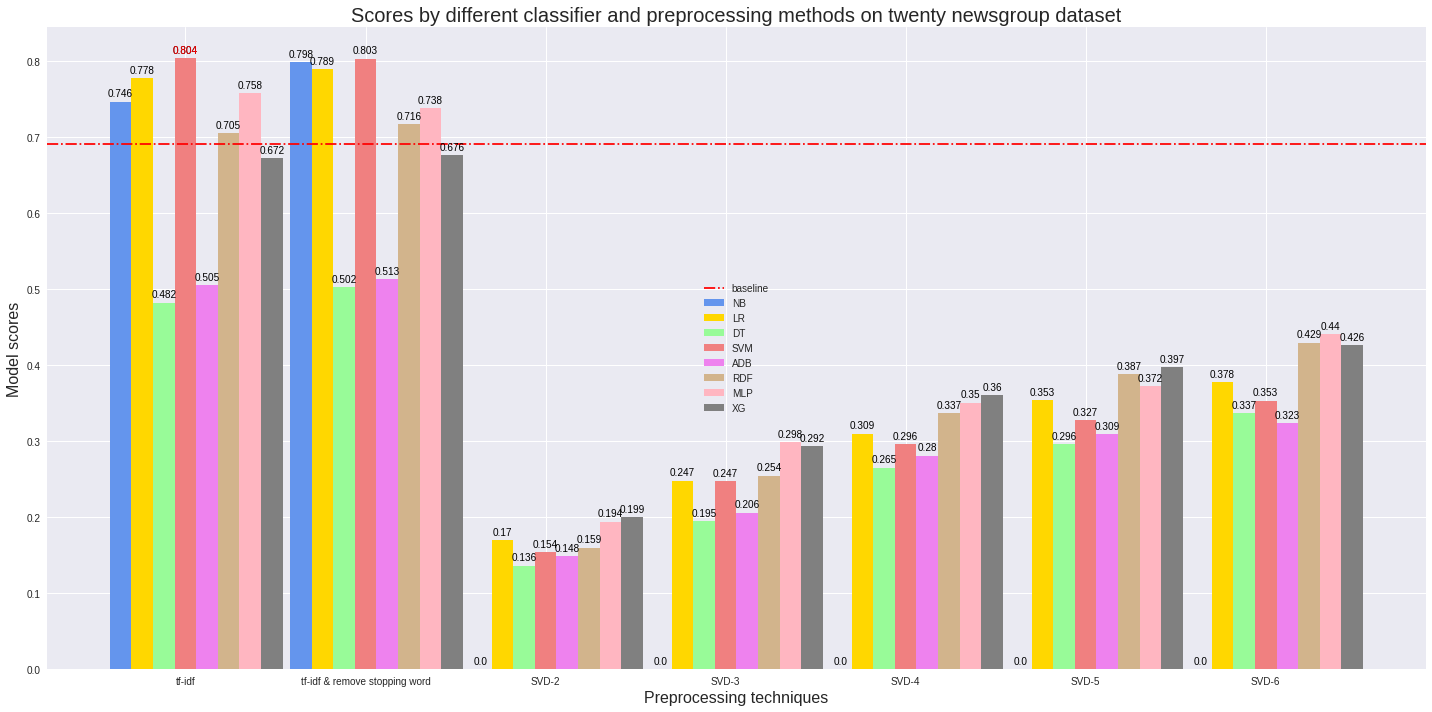

In [213]:
rects=[]
x = np.arange(len(dataset_list))  # the label locations
w = 0.12
width = [-w*3 + w*i for i in range(len(model_name_list))]  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
for i in range(len(model_name_list)):
    rect = ax.bar(list(x + width[i]), scores[0,i,:], w, label= model_name_list[i],color=[colors[i]]*len(scores[0,i,:]))
    rects.append(rect)

plt.axhline(y=0.69065, color='r', linestyle='-.',label='baseline')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model scores',fontsize=16)
ax.set_xlabel('Preprocessing techniques',fontsize=16)
ax.set_title('Scores by different classifier and preprocessing methods on twenty newsgroup dataset',fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(dataset_list)
ax.legend()

for _,_rect in enumerate(rects):
    autolabel(_rect)
max_label = np.where(scores[0,:,:] == np.max(scores[0,:,:]))
labelmax(rects[max_label[0][0]],max_label[1][0])

fig.tight_layout()
plt.savefig('fig/model_acc_20.eps')
plt.show()

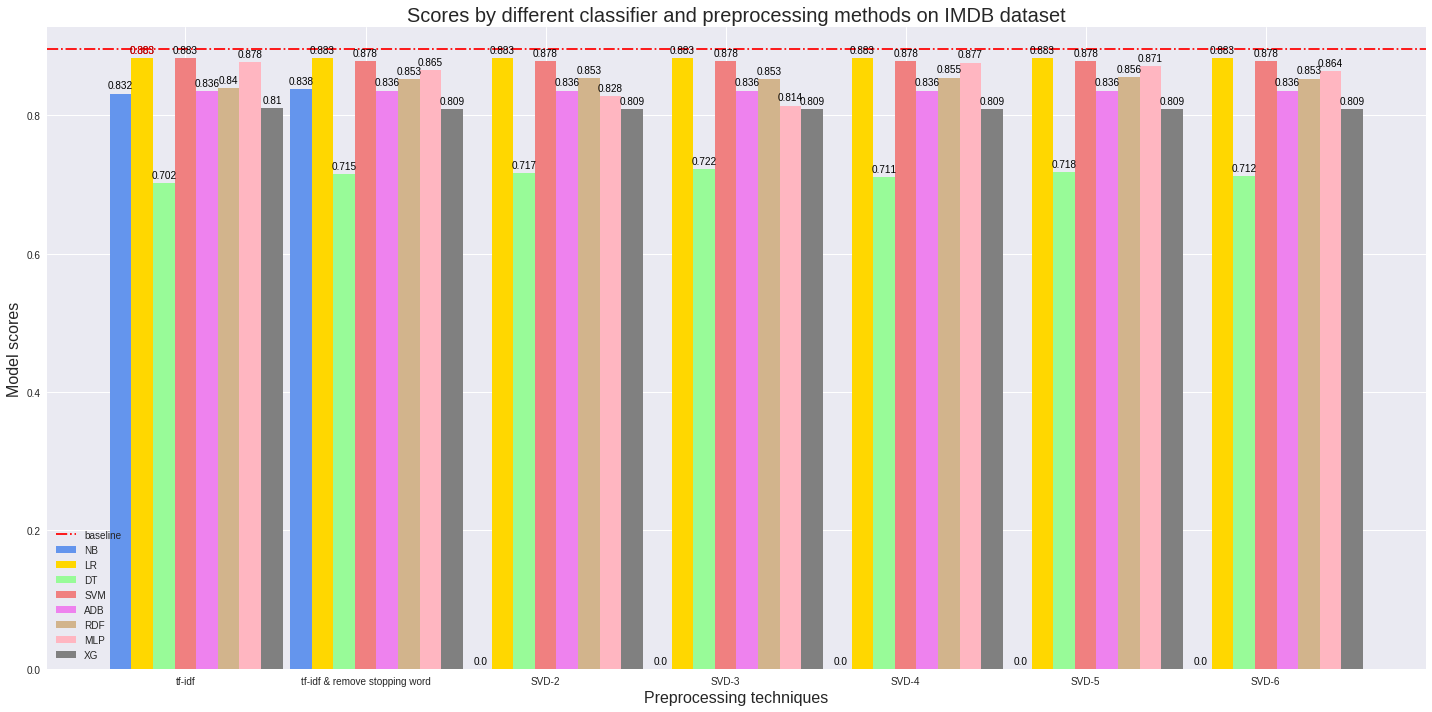

In [214]:
rects=[]
x = np.arange(len(dataset_list))  # the label locations
w = 0.12
width = [-w*3 + w*i for i in range(len(model_name_list))]  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
for i in range(len(model_name_list)):
    rect = ax.bar(list(x + width[i]), scores[1,i,:], w, label= model_name_list[i],color=[colors[i]]*len(scores[1,i,:]))
    rects.append(rect)
    
plt.axhline(y=0.8967, color='r', linestyle='-.',label='baseline')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model scores',fontsize=16)
ax.set_xlabel('Preprocessing techniques',fontsize=16)
ax.set_title('Scores by different classifier and preprocessing methods on IMDB dataset',fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(dataset_list)
ax.legend()

for _,_rect in enumerate(rects):
    autolabel(_rect)
max_label = np.where(scores[1,:,:] == np.max(scores[1,:,:]))

labelmax(rects[max_label[0][0]],max_label[1][0])

fig.tight_layout()
plt.savefig('fig/model_acc_imdb.eps')
plt.show()

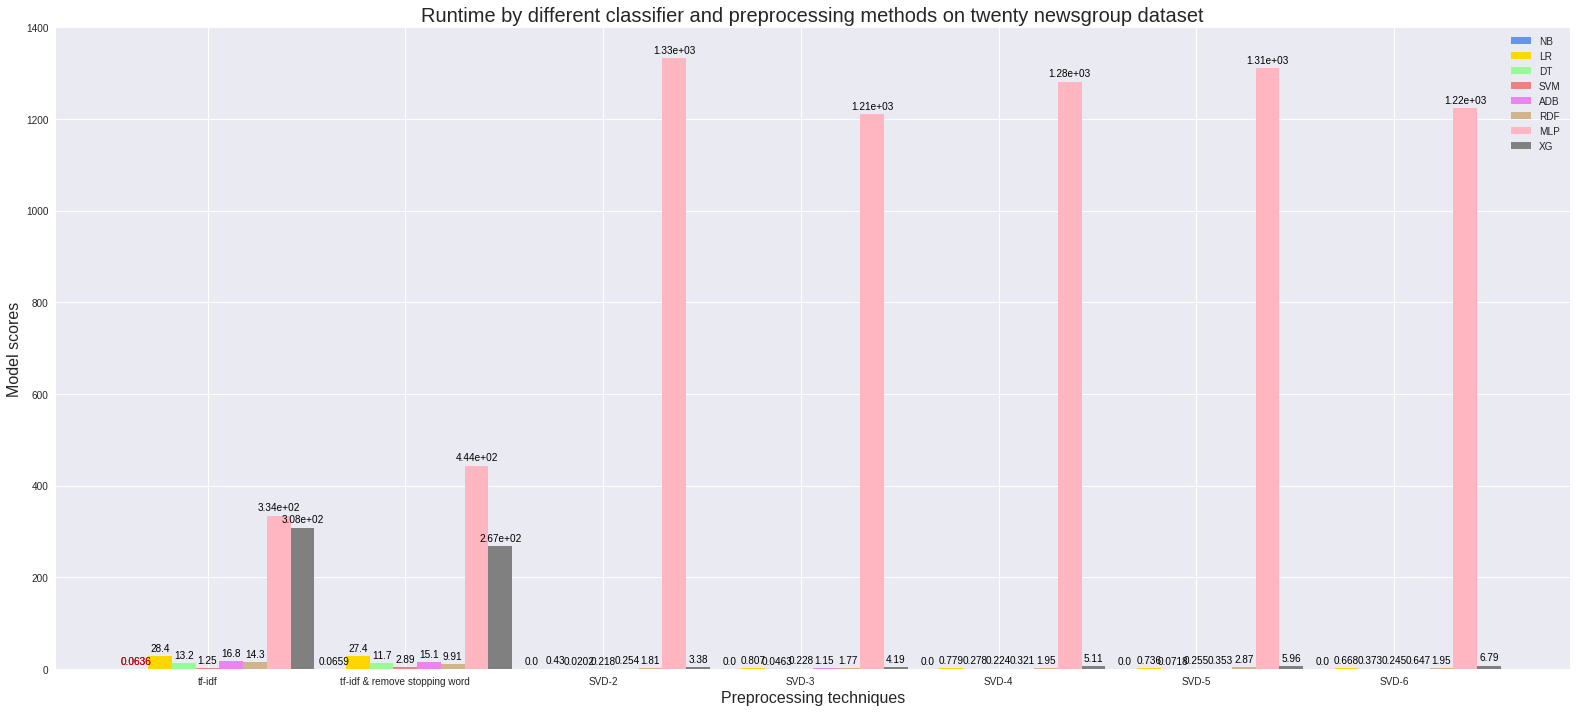

In [215]:
rects=[]
x = np.arange(len(dataset_list))  # the label locations
w = 0.12
width = [-w*3 + w*i for i in range(len(model_name_list))]  # the width of the bars

fig, ax = plt.subplots(figsize=(22,10))
for i in range(len(model_name_list)):
    rect = ax.bar(list(x + width[i]), runtime[0,i,:], w, label= model_name_list[i],color=[colors[i]]*len(runtime[0,i,:]))
    rects.append(rect)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model scores',fontsize=16)
ax.set_xlabel('Preprocessing techniques',fontsize=16)
ax.set_title('Runtime by different classifier and preprocessing methods on twenty newsgroup dataset',fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(dataset_list)
ax.legend()

for _,_rect in enumerate(rects):
    autolabel(_rect)
labelmax(rects[0],0)

fig.tight_layout()
plt.savefig('fig/model_runtime_20.eps')
plt.show()

In [216]:
rects

[<BarContainer object of 7 artists>,
 <BarContainer object of 7 artists>,
 <BarContainer object of 7 artists>,
 <BarContainer object of 7 artists>,
 <BarContainer object of 7 artists>,
 <BarContainer object of 7 artists>,
 <BarContainer object of 7 artists>,
 <BarContainer object of 7 artists>]

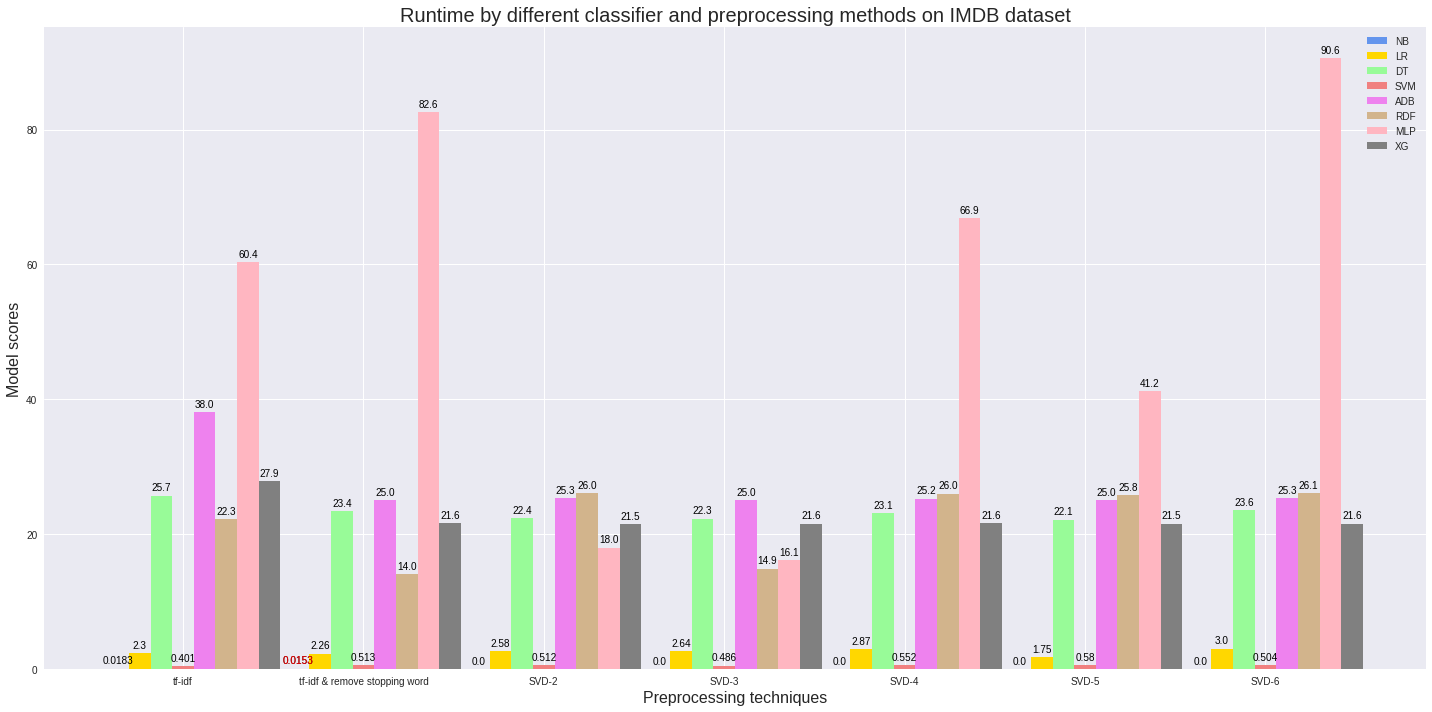

In [217]:
rects=[]
x = np.arange(len(dataset_list))  # the label locations
w = 0.12
width = [-w*3 + w*i for i in range(len(model_name_list))]  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
for i in range(len(model_name_list)):
    rect = ax.bar(list(x + width[i]), runtime[1,i,:], w, label= model_name_list[i],color=[colors[i]]*len(runtime[1,i,:]))
    rects.append(rect)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model scores',fontsize=16)
ax.set_xlabel('Preprocessing techniques',fontsize=16)
ax.set_title('Runtime by different classifier and preprocessing methods on IMDB dataset',fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(dataset_list)
ax.legend()

for _,_rect in enumerate(rects):
    autolabel(_rect)
    
labelmax(rects[0],1)

fig.tight_layout()
plt.savefig('fig/model_runtime_imdb.eps')
plt.show()

## Overall accuracy comparison

We choose tf-idf as preprocessing method (it is the best) and the best performed model parameters to compare the overall accuracy and runtime. The term *overall* means we fit the concatenated IMDB and Twenty Newsgroups training data in the same time and calculate accuracy on both datasets' test data. We know that accuracy is based on the portion of true positive prediction, so we directly calculate it based on the count true positve portion on the whole test dataset.

In [166]:
scores_overall = np.zeros((len(models_dict)+len(models_dict_notuning),len(dataset_list)))

In [167]:
twenty_dataset_dict[0][0].shape

for model_idx in tqdm_notebook(range(len(model_name_list))):
    for dataset_idx in range(len(dataset_list)):
        tmp_20 = scores[0,model_idx,dataset_idx] * twenty_dataset_dict[dataset_idx][2].shape[0]
        tmp_imdb = scores[1,model_idx,dataset_idx] * IMDB_dataset_dict[dataset_idx][2].shape[0]
        scores_overall[model_idx,dataset_idx] = (tmp_20 + tmp_imdb ) / (twenty_dataset_dict[dataset_idx][2].shape[0] + IMDB_dataset_dict[dataset_idx][2].shape[0])

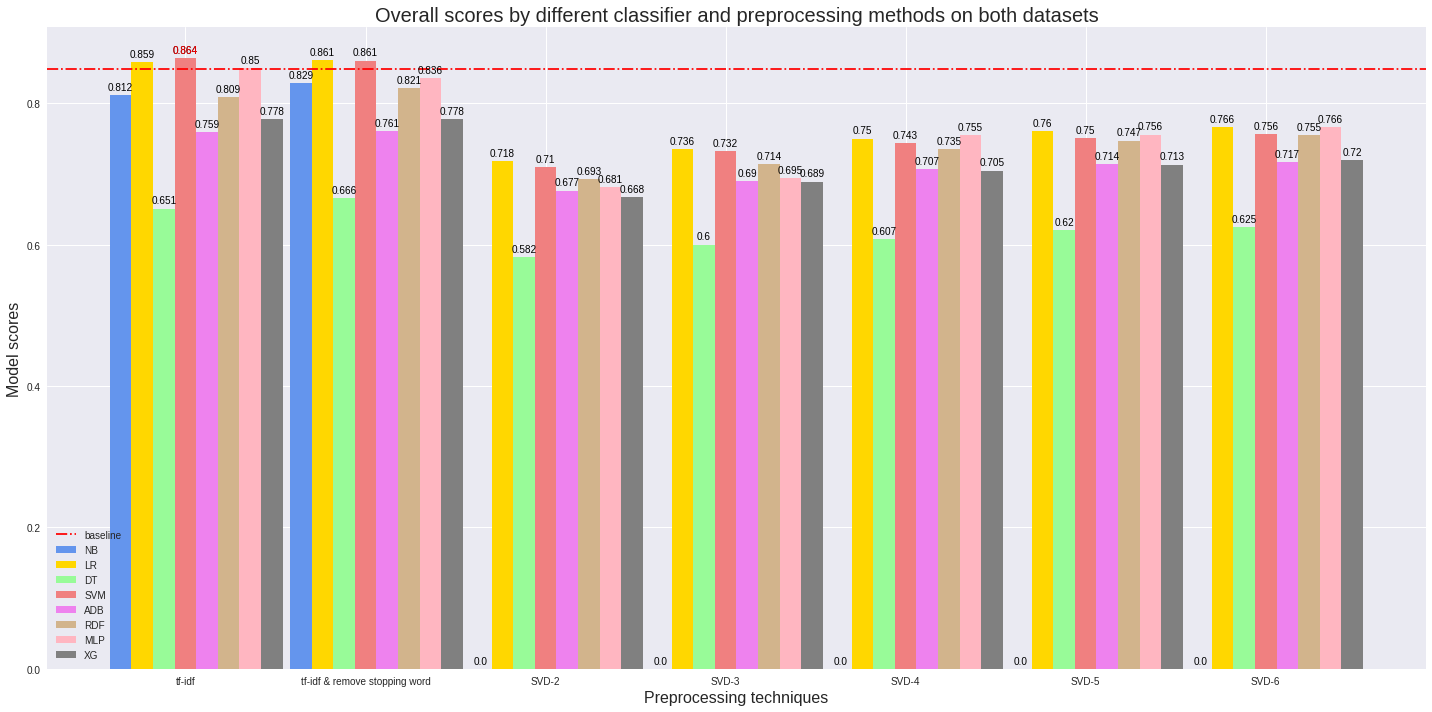

In [218]:
rects=[]
x = np.arange(len(dataset_list))  # the label locations
w = 0.12
width = [-w*3 + w*i for i in range(len(model_name_list))]  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
for i in range(len(model_name_list)):
    rect = ax.bar(list(x + width[i]), scores_overall[i,:], w, label= model_name_list[i],color=[colors[i]]*len(scores_overall[i,:]))
    rects.append(rect)

plt.axhline(y=0.849, color='r', linestyle='-.',label='baseline')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model scores',fontsize=16)
ax.set_xlabel('Preprocessing techniques',fontsize=16)
ax.set_title('Overall scores by different classifier and preprocessing methods on both datasets',fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(dataset_list)
ax.legend()

for _,_rect in enumerate(rects):
    autolabel(_rect)
max_label = np.where(scores_overall == np.max(scores_overall))
labelmax(rects[max_label[0][0]],max_label[1][0])

fig.tight_layout()
plt.savefig('fig/model_acc_overall.eps')
plt.show()